<a href="https://colab.research.google.com/github/JonathanCornish/Netflix-Scrape/blob/master/Wikipedia_Netflix_Scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import requests
import re
from bs4 import BeautifulSoup

In [19]:
orig_show_url = "https://en.wikipedia.org/wiki/List_of_Netflix_original_programming"
orig_film_url = "https://en.wikipedia.org/wiki/List_of_Netflix_original_films"
orig_comedy_url = "https://en.wikipedia.org/wiki/List_of_Netflix_original_stand-up_comedy_specials"

In [20]:
import pandas as pd

In [21]:
# get all the tables from the Wikipedia page on all Netflix original stand-ups
comedy_tables_all = pd.read_html(orig_comedy_url, attrs = {"class": "wikitable"})
# show the number of tables on the page containing info on Netflix's original stand-ups programming over time
len(comedy_tables_all)

4

In [22]:
comedy_tables_all[0].tail()

,Title,Premiere,Length,Language
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English
234,Awaiting release,Awaiting release,Awaiting release,Awaiting release
235,Sam Jay: 3 in the Morning[1],"August 4, 2020",TBA,English
236,"Rob Schneider: Asian Momma, Mexican Kids[2]","August 11, 2020",TBA,English


In [23]:
# By inspecting the Wikipedia page we can see what each of these tables are. Let's name them for clarity:
# released comedy specials:
released_com_specials = comedy_tables_all[0]
# released comedy series & collections:
released_com_series = comedy_tables_all[1]
# upcoming comedy specials:
upcom_com_specials = comedy_tables_all[2]
# upcoming comedy series & collections:
upcom_com_series = comedy_tables_all[3]

In [24]:
# let's inspect the table showing info on previously released Netflix comedy specials:
released_com_specials.tail()

,Title,Premiere,Length,Language
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English
234,Awaiting release,Awaiting release,Awaiting release,Awaiting release
235,Sam Jay: 3 in the Morning[1],"August 4, 2020",TBA,English
236,"Rob Schneider: Asian Momma, Mexican Kids[2]","August 11, 2020",TBA,English


In [25]:
# inspect the type of each column:
released_com_specials.dtypes

Title       object
Premiere    object
Length      object
Language    object
dtype: object

In [26]:
# change the Premiere column from object to string:
released_com_specials['Premiere'] = released_com_specials['Premiere'].astype('string')
released_com_specials.dtypes

Title       object
Premiere    string
Length      object
Language    object
dtype: object

In [27]:
# from several columns above we see that there is a line showing not a date but 'Awaiting release', which throws off our calculation.
# let's create a new data table which deletes any line where the word 'Awaiting' appears within the Premiere column:
released_com_specials_2 = released_com_specials[~released_com_specials.Premiere.str.contains("Awaiting")]
# and print out to show it's gone:
released_com_specials_2.tail()

,Title,Premiere,Length,Language
231,Jim Jefferies: Intolerant,"July 7, 2020","1 hour, 6 min.",English
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English
235,Sam Jay: 3 in the Morning[1],"August 4, 2020",TBA,English
236,"Rob Schneider: Asian Momma, Mexican Kids[2]","August 11, 2020",TBA,English


In [29]:
# when we try to turn the Premiere column into date-time it throws off an error. 
# Upon inspecting the Wikipedia table, we see that the reason for this error is because there is an endnote reference in one of the cells in the Premiere column (i.e. [1] appears).
# the following code ain't pretty, but gets the job done of preprocessing this column to account for endnote references
# released_com_specials_2['Premiere'] = released_com_specials_2['Premiere'].str.strip().str.replace('[[1]]','').str.replace(']','').str.replace('[','')

# This code uses regular expressions in Pandas to replace any digits or characters within brackets, as well as any brackets themselves:
released_com_specials_2_regex = released_com_specials_2.replace(to_replace = "\[([A-Za-z0-9_]+)\]", value = '', regex = True)

released_com_specials_2_regex

,Title,Premiere,Length,Language
0,Bill Burr: You People Are All the Same,"August 16, 2012","1 hour, 8 min.",English
1,Craig Ferguson: I'm Here to Help,"March 15, 2013","1 hour, 21 min.",English
2,John Hodgman: Ragnarok,"June 20, 2013","1 hour, 7 min.",English
3,Mike Birbiglia: My Girlfriend's Boyfriend,"August 23, 2013","1 hour, 15 min.",English
4,Iliza Shlesinger: War Paint,"September 1, 2013","1 hour, 15 min.",English
...,...,...,...,...
231,Jim Jefferies: Intolerant,"July 7, 2020","1 hour, 6 min.",English
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English
235,Sam Jay: 3 in the Morning,"August 4, 2020",TBA,English


In [31]:
# after that pre-processing step, we can now convert the Premiere column into a release year
# we create a new column for this.
# note that if this step doesn't work, it is likely that we need to do further pre-processing for the Premiere column. i.e., in that situation it's likely that not all the cells are in the correct format etc to be converted into date-time formatting
# if that's the case then go check all the rows in the Premiere column of the wikipedia table to see what looks out of format etc
released_com_specials_2_regex['Release-Date'] = pd.to_datetime(released_com_specials_2_regex['Premiere'])
released_com_specials_2_regex

,Title,Premiere,Length,Language,Release-Date
0,Bill Burr: You People Are All the Same,"August 16, 2012","1 hour, 8 min.",English,2012-08-16
1,Craig Ferguson: I'm Here to Help,"March 15, 2013","1 hour, 21 min.",English,2013-03-15
2,John Hodgman: Ragnarok,"June 20, 2013","1 hour, 7 min.",English,2013-06-20
3,Mike Birbiglia: My Girlfriend's Boyfriend,"August 23, 2013","1 hour, 15 min.",English,2013-08-23
4,Iliza Shlesinger: War Paint,"September 1, 2013","1 hour, 15 min.",English,2013-09-01
...,...,...,...,...,...
231,Jim Jefferies: Intolerant,"July 7, 2020","1 hour, 6 min.",English,2020-07-07
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English,2020-07-14
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English,2020-07-21
235,Sam Jay: 3 in the Morning,"August 4, 2020",TBA,English,2020-08-04


In [32]:
# create a new column called 'Release-Year' based off of the year
released_com_specials_2_regex['Release-Year'] = pd.DatetimeIndex(released_com_specials_2_regex['Release-Date']).year
released_com_specials_2_regex

,Title,Premiere,Length,Language,Release-Date,Release-Year
0,Bill Burr: You People Are All the Same,"August 16, 2012","1 hour, 8 min.",English,2012-08-16,2012
1,Craig Ferguson: I'm Here to Help,"March 15, 2013","1 hour, 21 min.",English,2013-03-15,2013
2,John Hodgman: Ragnarok,"June 20, 2013","1 hour, 7 min.",English,2013-06-20,2013
3,Mike Birbiglia: My Girlfriend's Boyfriend,"August 23, 2013","1 hour, 15 min.",English,2013-08-23,2013
4,Iliza Shlesinger: War Paint,"September 1, 2013","1 hour, 15 min.",English,2013-09-01,2013
...,...,...,...,...,...,...
231,Jim Jefferies: Intolerant,"July 7, 2020","1 hour, 6 min.",English,2020-07-07,2020
232,Urzila Carlson: Overqualified Loser,"July 14, 2020","1 hour, 2 min.",English,2020-07-14,2020
233,Jack Whitehall: I'm Only Joking,"July 21, 2020",58 min.,English,2020-07-21,2020
235,Sam Jay: 3 in the Morning,"August 4, 2020",TBA,English,2020-08-04,2020


In [33]:
# let's show the number of released comedy specials produced each year:
released_com_specials_2_regex['Release-Year'].value_counts(ascending=False)

2018    59
2017    54
2019    45
2020    27
2016    27
2015    12
2013     6
2014     5
2012     1
Name: Release-Year, dtype: int64

In [34]:
# do the same thing but show the counts as a percentage of total. E.g. years 2017 + 2018 + 2019 combined are ~66% of total original comedies released
released_com_specials_2_regex['Release-Year'].value_counts(normalize=True)

2018    0.250000
2017    0.228814
2019    0.190678
2020    0.114407
2016    0.114407
2015    0.050847
2013    0.025424
2014    0.021186
2012    0.004237
Name: Release-Year, dtype: float64

In [36]:
# great - now let's put each of these into their own variable which we'll ultimately put into a bar chart
year_list = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
for year in year_list:
  print(year,released_com_specials_2_regex['Release-Year'].value_counts()[year])

2012 1
2013 6
2014 5
2015 12
2016 27
2017 54
2018 59
2019 45
2020 27


In [40]:
# let's put all this into a function and then call the function for the other tables on the page:
year_list_try = []
for year in range(2012,2021):
  movie_count = {year: released_com_specials_2_regex['Release-Year'].value_counts()[year]}
  year_list_try.append(movie_count)
  # released_com_specials_2_regex['Release-Year'].value_counts()[year]
print(year_list_try)

[{2012: 1}, {2013: 6}, {2014: 5}, {2015: 12}, {2016: 27}, {2017: 54}, {2018: 59}, {2019: 45}, {2020: 27}]


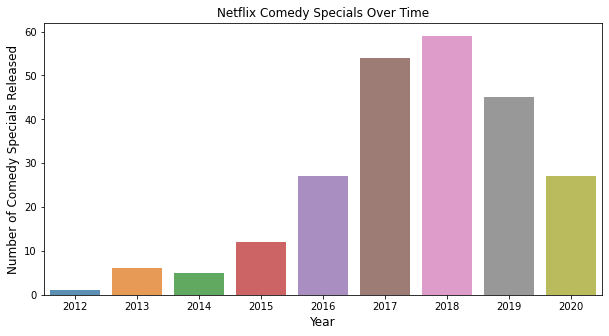

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
movie_years = released_com_specials_2_regex['Release-Year'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(movie_years.index, movie_years.values, alpha=0.8)
plt.title('Netflix Comedy Specials Over Time')
plt.ylabel('Number of Comedy Specials Released', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

In [ ]:
# let's put all this into a function and then call the function for the other tables on the page:
